# Dissertation

## Research into the techniques and methods to achieve state of the art accuracy in flower species identification


In [12]:
###imports###
import numpy as np
import tensorflow as tf
import scipy.io
from scipy import io
import time
import sys
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.python.framework import graph_util
from tensorflow.keras.callbacks import TensorBoard
import pickle
import datetime
import time
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import OneHotEncoder
import logging
#import skimage.io
import random
import PIL
from pathlib import Path

In [13]:
print(tf.__version__)

2.4.0-rc0


In [14]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [15]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

    print("Please install GPU version of TF")

Please install GPU version of TF


In [16]:
#makes all outputs be in float format rather than exponentials
#np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [17]:
#Set Parameters
IMG_SIZE = 150 #this parameter sets image dimensions as 50*50
DATE = datetime.datetime.now().strftime('%d-%b-%Y')
MODEL_PATH = f'models/{DATE}/'
MODEL_NAME = 'FlowerClassifierTrial.model'.format(int(time.time()))
TENSORBOARD = TensorBoard(log_dir=f'logs\\{MODEL_NAME}')

In [18]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Load Directory

In [19]:
# ###Directory for MacBook
# mac_URL = '/Volumes/T7/Uni/Github/thesis/flowerDataset/Flower'
# mac_labels = '/Volumes/T7/Uni/Github/thesis/flowerDataset/imagelabels.mat'
# mac_dataSplit = '/Volumes/T7/Uni/Github/thesis/flowerDataset/setid.mat'
# mac_loaded_images = '/Volumes/T7/Uni/loaded_images.npy'
# mac_image_train='/Volumes/T7/Uni/image_train.npy'
# mac_label_train = '/Volumes/T7/Uni/label_train.npy'
# mac_image_test = '/Volumes/T7/Uni/image_test.npy'
# mac_label_test = '/Volumes/T7/Uni/label_test.npy'
# mac_image_val = '/Volumes/T7/Uni/image_val.npy'
# mac_label_val = '/Volumes/T7/Uni/label_val.npy'

# ###Directory for PC
# pc_URL = 'E:/Github/thesis/flowerDataset/Flower'
# pc_labels = 'E:/Github/thesis/flowerDataset/imagelabels.mat'
# pc_dataSplit = 'E:/Github/thesis/flowerDataset/setid.mat'
# pc_loaded_images = 'E:/Dissertation/data/loaded_images.npy'
# pc_image_train = 'E:/Dissertation/data/image_train.npy'
# pc_label_train = 'E:/Dissertation/data/label_train.npy'
# pc_image_test = 'E:/Dissertation/data/image_test.npy'
# pc_label_test = 'E:/Dissertation/data/label_test.npy'
# pc_image_val = 'E:/Dissertation/data/image_val.npy'
# pc_label_val = 'E:/Dissertation/data/label_val.npy'

In [20]:
def get_directories():
    if os.path.exists(mac_URL) and os.path.exists(mac_labels) and os.path.exists(
            mac_dataSplit) and os.path.exists(mac_loaded_images):
        return mac_URL, mac_labels, mac_dataSplit, mac_loaded_images, mac_image_train, mac_label_train, mac_image_test, mac_label_test,mac_image_val, mac_label_val 
    else:
        return pc_URL, pc_labels, pc_dataSplit, pc_loaded_images, pc_image_train, pc_label_train, pc_image_test, pc_label_test, pc_image_val, pc_label_val

In [21]:
#URL_dir, labels_dir, dataSplit_dir, loaded_images_dir, image_train_dir, label_train_dir, image_test_dir, label_test_dir, image_val_dir, label_val_dir = get_directories()

In [22]:
URL_dir = '/Volumes/T7/Uni/Github/thesis/flowerDataset/Flower'
labels_dir = '/Volumes/T7/Uni/Github/thesis/flowerDataset/imagelabels.mat'
dataSplit_dir = '/Volumes/T7/Uni/Github/thesis/flowerDataset/setid.mat'
loaded_images_dir = '/Volumes/T7/Uni/Github/thesis/Dissertation/data/loaded_images.npy'
image_train_dir ='/Volumes/T7/Uni/Github/thesis/Dissertation/data/image_train.npy'
label_train_dir = '/Volumes/T7/Uni/Github/thesis/Dissertation/data/label_train.npy'
image_test_dir = '/Volumes/T7/Uni/Github/thesis/Dissertation/data/image_test.npy'
label_test_dir = '/Volumes/T7/Uni/Github/thesis/Dissertation/data/label_test.npy'
image_val_dir = '/Volumes/T7/Uni/Github/thesis/Dissertation/data/image_val.npy'
label_val_dir = '/Volumes/T7/Uni/Github/thesis/Dissertation/data/label_val.npy'

In [23]:
print(labels_dir)

/Volumes/T7/Uni/Github/thesis/flowerDataset/imagelabels.mat


### Load DataSet and Labels

In [24]:
data_labels = io.loadmat(labels_dir)
data_labels = data_labels.items()
data_labels = list(data_labels)

In [25]:
df = pd.DataFrame(data_labels)

In [26]:
labels = df[1][3][0] #loads the labels that is stored in dataframe format

In [27]:
labels

array([77, 77, 77, ..., 62, 62, 62], dtype=uint8)

In [28]:
len(labels)

8189

In [29]:
UNIQUE_LABELS = np.unique(labels)
UNIQUE_LABELS

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102], dtype=uint8)

In [30]:
#Got loading files code from link below
#https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
#Function gets all the images loaded up
def load_images_from_folder(URL):
    images = []
    for filename in os.listdir(URL):
        #img = cv2.imread(os.path.join(URL,filename))
        img = cv2.resize(cv2.imread(os.path.join(URL,filename), cv2.COLOR_BGR2RGB), (IMG_SIZE, IMG_SIZE))
        img = np.reshape(img,[IMG_SIZE,IMG_SIZE,3])
        if img is not None:
            images.append(img)
    np.save(loaded_images_dir, images)
    return images

In [31]:
#No need to run this cell if image already loaded.
#load_images_from_folder(URL_dir)

In [32]:
#if images are already loaded, just load the file here rather than running function again.
image_data = np.load(loaded_images_dir, allow_pickle=True)

In [33]:
#shows the shape of the image_data, the number of images, the dimensions and number of colour channels
image_data.shape

(8189, 150, 150, 3)

In [34]:
image_data[0].shape

(150, 150, 3)

In [35]:
#combine image with labels
def randomised_dataset(image_data, labels):
    np.random.seed(8)
    indices = np.arange(image_data.shape[0])
    print(indices)
    np.random.shuffle(indices)
    image_data = image_data[indices]
    labels = labels[indices]
    return image_data, labels

In [36]:
#image_data, labels = randomised_dataset(image_data, labels)

In [37]:
print(image_data.shape)

(8189, 150, 150, 3)


In [38]:
# # Label Encoder

mlb = LabelBinarizer()
converted_labels = np.array(mlb.fit_transform(labels))

In [39]:
converted_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [40]:
def convert_label(labels):
    new_labels = []
    for i in range(len(labels)):
        new_labels.insert(i, [labels[i]])
    return np.array(new_labels)

In [41]:
#converted_labels = convert_label(labels)

In [42]:
#converted_labels.shape

In [43]:
len(converted_labels)

8189

In [44]:
converted_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Training and Testing Split

In [45]:
#citation code from https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
#splitting the image dataset into the ratio for training, validation and testing data
def split_data(image_data, converted_labels):
    
    train_ratio = 0.75
    validation_ratio = 0.15
    test_ratio = 0.10

    image_train, image_test, label_train, label_test = train_test_split(image_data, converted_labels, test_size=1 - train_ratio, random_state=42)

    #the test from previous line which is 25% of dataset is passed into the line below to be 
    #further split into 15% for validation and 10% for testing

    image_val, image_test, label_val, label_test = train_test_split(image_test, label_test, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42) 

    print('image_train',image_train.shape)
    print('label_train',label_train.shape)
    print('image_test',image_test.shape)
    print('label_test',label_test.shape)
    print('image_val', image_val.shape)
    print('label_val', label_val.shape)

    np.save(image_train_dir, image_train)
    np.save(label_train_dir, label_train)
    np.save(image_test_dir, image_test)
    np.save(label_test_dir, label_test)
    np.save(image_val_dir, image_val)
    np.save(label_val_dir, label_val)



In [46]:
split_data(image_data,converted_labels)

image_train (6141, 150, 150, 3)
label_train (6141, 102)
image_test (820, 150, 150, 3)
label_test (820, 102)
image_val (1228, 150, 150, 3)
label_val (1228, 102)


In [47]:
image_train = np.load(image_train_dir, allow_pickle=True)
image_test = np.load(image_test_dir, allow_pickle=True)
label_train = np.load(label_train_dir, allow_pickle=True)
label_test = np.load(label_test_dir, allow_pickle=True)
image_val = np.load(image_val_dir, allow_pickle=True)
label_val = np.load(label_val_dir, allow_pickle=True)

In [48]:
image_test.shape

(820, 150, 150, 3)

In [49]:
label_val[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Feature Scaling

In [50]:
#converts the images to the range of 0 - 1.0 
image_train = image_train/255.0
image_test = image_test/255.0
image_val = image_val/255.0

In [51]:
image_train.shape

(6141, 150, 150, 3)

In [52]:
label_train.shape

(6141, 102)

In [53]:
label_test.shape

(820, 102)

In [54]:
len(image_test)

820

In [55]:
label_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [56]:
# number of classes/ flowers
NUM_CLASSES = 102
NUM_CLASSES

102

In [59]:
label_train.shape

(6141, 102)

In [60]:
label_train[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0,

# Custom CNN model

In [63]:
# name of model
name_model = 'test-{}'.format(int(time.time()))

In [64]:
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(name_model))

In [65]:
# batch_size = 6
# epochs = 30
# verbose= 0
# act = 'relu'

In [66]:
def create_cnn_model():
    # tf.reset_default_graph()
    model = Sequential()
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    
    # INPUT LAYER
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2,2)))

    # HIDDEN LAYER 1
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))

    # HIDDEN LAYER 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))
    
    # HIDDEN LAYER 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))
    
    # HIDDEN LAYER 4
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))

    # Fully Connected
    model.add(Flatten()) # converts the 3D feature maps to 1D feature vectors
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25)) # reduces overfitting

    # OUTPUT LAYER
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [67]:
model = create_cnn_model()

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 73, 73, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)       

In [69]:
image_train.shape

(6141, 150, 150, 3)

In [70]:
label_train.shape

(6141, 102)

In [71]:
image_val.shape

(1228, 150, 150, 3)

In [72]:
label_val.shape

(1228, 102)

In [73]:
image = image_train[0]

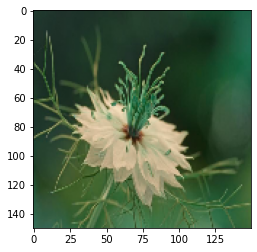

In [74]:
plt.imshow(image)

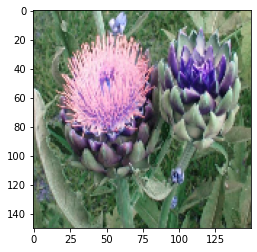

In [75]:
plt.imshow(image_val[0])

In [ ]:
history = model.fit(image_train, label_train, batch_size=32, epochs=5, validation_data=(image_val, label_val), verbose=1, callbacks = [tensorboard])

Epoch 1/5
192/192 [==============================] - ETA: 0s - loss: 4.2380 - accuracy: 0.0863

In [ ]:
#saving model
#model.save(f'{MODEL_PATH}')

In [ ]:
#loading model
#model =  tf.keras.models.load_model(f'{MODEL_PATH}')
#model = tf.keras.models.load_model(f'E:/GoogleSync/Masters/Dissertation/models/24-Jun-2021') 

# Evaluation

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
mlflow.keras.autolog()



with mlflow.start_run():
        
        #model.compile(loss=tf.keras.losses.categorical_crossentropy,
        #optimizer=tf.keras.optimizers.Adam(),
        #metrics=['accuracy'])
        # Fit our model
        history = model.fit(image_train, label_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(image_val, label_val))

        score = model.evaluate(image_test, label_test, batch_size=batch_size, verbose = 0)
        
        mlflow.log_param("activation function", act)
        mlflow.log_metric("test loss", score[0])
        mlflow.log_metric("test accuracy", score[1])
        mlflow.log_metric("test accuracy", score[1])
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        mlflow.keras.log_model(model, "standardCNN")        

In [ ]:
!mlflow ui

In [ ]:
#function that returns loss value & metrics values
model.evaluate(image_test, label_test)

In [1]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=logs

In [ ]:
label_test.shape

In [ ]:
label_test[0][52]

In [ ]:
def prediction_accuracy(image_test, model):
    #going through each of the test images
    count = 0
    for i in range(len(image_test)): #going through all test images
        img = image_test[i] #load in the image
        
        img = img.reshape(-1, 100, 100, 3) #get it in the right shape for model.predict
        
        prediction = model.predict(img).flatten() #using model predict to get what it thinks is the answer
        
        # prediction.astype(np.int) #converts predictions to integers
        
        pred_index = np.argmax(prediction) # grabs the INDEX of the best prediction
        
        max_pred = max(prediction) # grabs the SCORE of best prediction
        # print(prediction)
        # print(pred_index)
        
        test_label_value = label_test[i][pred_index] # gets the actual test label at the same index
        # print(test_label_value)
        if test_label_value == 1:
            #print("CORRECT PREDICTION")
            count += 1
            
#         # FIND THE INDEX WHERE THE VALUE = 1
#         for j in range(len(predicted_label)):
#             if predicted_label[j] == 1 : #find the point when it finds 1 
#                 if label_test[i][j] == 1: #check if at this exact point is also 1  whic means correct prediction
#                     count+=1 #increase number of correct count by 1
#                     print(count)
#                     break
    print(f"num correct - {count}")
    accuracy = (count/len(label_test))*100
    per_symbol = '%'
    print(f'accuracy is {accuracy} {per_symbol}')        

In [ ]:
prediction_accuracy(image_test, model) 

In [ ]:
#checks for best model
runs = mlflow.search_runs(experiment_ids=experiment_id,
                          order_by=['metrics.mae'], max_results=1)

In [ ]:
runs.loc[0]

# Segmentation algorithms

# MASK RCNN CONFIG

In [ ]:
os.getcwd()

In [ ]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath("E:\Dissertation")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "data\img")

## Extract Masks from dataset

In [ ]:
#gets all the image paths stores in a list
def get_img_paths(URL_dir):
    img_paths = []
    for path in os.listdir(URL_dir):
        full_path = os.path.join(URL_dir, path)
        if os.path.isfile(full_path):
            img_paths.append(full_path)

    return img_paths

In [ ]:
img_paths = get_img_paths(URL_dir)   

In [ ]:
len(img_paths)

In [ ]:
### Plots each object on a copy of the image and attempts to remove noise

def plot_mask(image, masks):
    all_masks = list()
    masks = masks.astype(int)
    # print(masks.shape)
    
    for i in range(masks.shape[2]):
        temp = np.copy(image)
        for j in range(temp.shape[2]):
            temp[:,:,j] = temp[:,:,j] * masks[:,:,i]
        all_masks.append(temp)
#         plt.figure(figsize=(8,8))
#         plt.imshow(temp)
    # print(f"Number of masks: {len(all_masks)}")
    return all_masks

In [ ]:
### Overlay all masks onto a black canvas

def combine_mask_objects(masks, shape):
    canvas = np.zeros(shape, np.uint8)
#     print("ORIGINAL CANVAS")
#     plt.figure(figsize=(8,8))
#     plt.imshow(canvas)
    for i, obj in enumerate(masks):
        canvas = cv2.add(canvas, obj)
#         plt.figure(figsize=(8,8))
#         plt.imshow(canvas)
    return canvas

### Saves all masks for each image in a separate directory

In [ ]:
def save_image(img_id, img, folder):
    # checks if the img_id folder exists, if not create one
    img = PIL.Image.fromarray(img, 'RGB')
    img.save(f'{folder}/{img_id}.png')
    return True       

In [ ]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [ ]:
def generate_masks(folder_name, img_paths):
    # checks if the masks folder exists, if not creates one
    print(os.getcwd())
    if not os.path.isdir(folder_name):
        os.makedirs(folder_name)
    for img_path in img_paths:
        print(img_path)
        img_id = Path(img_path).stem
        print(img_id)
        image = skimage.io.imread(img_path)
        # check if image is in rgba format
        if image.shape[2] > 3:
            # convert to rgb
            image = rgba2rgb(image)
        # Run detection
        results = model.detect([image], verbose=0)
        # Visualize results
        r = results[0]
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], UNIQUE_LABELS, r['scores'])

        masks = plot_mask(np.copy(image), r["masks"])

        if len(masks) > 0:
            processed_image = combine_mask_objects(masks, masks[0].shape)
            print(masks)
            save_image(i, processed_image, folder_name)
        else:
            print(f"{img_id} has no masks!")
            save_image(img_id, image, folder_name)
    return "COMPLETE!"

In [ ]:
# path = os.path.join("E:\Dissertation")
# os.chdir(path)
# UNCOMMENT THIS LINE TO EXTRACT MASKS FROM DATATSET
# BEWARE THIS PROCESS CAN TAKE HOURS TO FINISH!
generate_masks("masks", img_paths)

In [ ]:
TRAIN_MASK_DIR = os.path.join(MAIN_PATH, 'data\train_masks')
DEV_SEEN_MASK_DIR = os.path.join(MAIN_PATH, 'data\dev_seen_masks')
DEV_UNSEEN_MASK_DIR = os.path.join(MAIN_PATH, 'data\dev_unseen_masks')

# 3. Create feature vector of object masks

In [ ]:
from pathlib import Path

def extract_id(name):
    filename = Path(name).stem
    # print(filename)
    return filename

def generate_data(df, directory):
    # dataset con
    ids = df["id"].to_numpy()
    labels = df["label"].to_numpy()
        
    X = []
    y = []
    
    for root, _, files in os.walk(directory):
        print(root)
        count = 0
        for file in tqdm(files):
            # print(f"IMAGE: {file}")
            # get full path of the mask
            full_path = os.path.join(root, file)
            # extract the image id from file
            img_id = extract_id(file)
            # get tensor of the mask
            image = Image.open(full_path)
            image = image.resize((224, 224))
            image_vect = np.asarray(image)
            # print(image_vect.shape)
            # find the index for the image_id
            idx = np.where(ids == int(img_id))[0][0]
            # print(df.iloc[idx])

            # get the label for that image_id
            label = labels[idx]

            # Append features and labels to data lists
            X.append(image_vect)
            y.append(label)
        break
    return np.array(X), np.array(y)

X, y = generate_data(TRAIN_DF, TRAIN_MASK_DIR)

# uncomment to generate training data for dev masks
# X, y = generate_data(DEV_SEEN_DF, DEV_SEEN_MASK_DIR)
# X, y = generate_data(DEV_UNSEEN_DF, DEV_UNSEEN_MASK_DIR)
print(X.shape, y.shape)

# Transfer Learning

In [ ]:
resnet = ResNet152V2(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top=False, # removes last layer of the resnet model
)

for layer in resnet.layers:
    layer.trainable = False

x = Flatten()(resnet.output)

prediction = Dense(1, activation="softmax")(x)

resnet_model = Model(inputs=resnet.input, outputs=prediction)

# GANs

# Analysis of Results